In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Extract and Transform
train_set=torchvision.datasets.FashionMNIST(root='./data',train=True,download=True,
                                           transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
len(train_set)

60000

In [5]:
train_set.targets   #1st image is 9 and so on..

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
#how many of each label exist
train_set.targets.bincount()       #result: balanced dataset

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [7]:
sample=next(iter(train_set))

len(sample)      # sample contains 2 items, and this is because the dataset contains image-label pairs.
                 #  Each sample we retrieve from the training set contains the image data as a tensor and
                 #  the corresponding label as a tensor.

2

In [8]:
image,label=sample   #same as image=sample[0]
                     #        label=sample[1] 

In [9]:
print(type(image))
print(type(label))

<class 'torch.Tensor'>
<class 'int'>


In [10]:
print(image.shape)
#print(label.shape)

torch.Size([1, 28, 28])


Label: tensor(9)


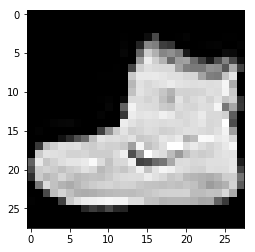

In [11]:
plt.imshow(image.squeeze(),cmap="gray")
print("Label:",torch.tensor(label))

In [12]:
#loading data
data_loader=torch.utils.data.DataLoader(train_set,batch_size=100)  #get batch

In [13]:
batch=next(iter(data_loader))
len(batch)

2

In [14]:
images,labels=batch

print(type(images))
print(type(labels))

print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([100, 1, 28, 28])
torch.Size([100])


In [15]:
print(images[0].shape)
print(labels[0])

torch.Size([1, 28, 28])
tensor(9)


Labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8])


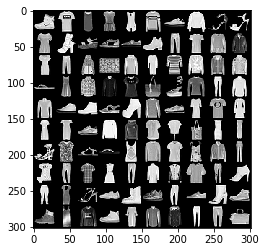

In [16]:
grid=torchvision.utils.make_grid(images,nrow=10)
plt.imshow(np.transpose(grid,(1,2,0)))     #or plt.imshow(grid.permute(1,2,0))     
print("Labels:",labels)

#The reason for using plt.imshow(np.transpose(grid, (1,2,0))):
#For a colored image... plt.imshow takes image dimension in following form [height width channels]
#...while pytorch follows [channels height width]... so for compatibility we have to change pytorch dimensions
#so that channels appear at end... the standard representation of array is [axis0 axis1 axis2].... 
#so we have to convert (0,1,2) to (1,2,0) form to make it compatible for imshow....



In [17]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolution layers
        self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        
        #Linear layers
        self.fc1=nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2=nn.Linear(in_features=120,out_features=60)
        self.out=nn.Linear(in_features=60,out_features=10)
        
        #If we count the input layer,then there are total 6 layers
    
    #In neural network programming, the forward method of a network instance explicitly defines the network's transformation
    def forward(self,t):
        #(1) i/p layer
        t=t     #it is identity matrix,in most cases we dont define input layer as whatever is input that is going to be output.
        
        #(2) 1st hidden conv. layer
        t=self.conv1(t)              #When want to call the forward() method of a nn.Module instance,
                                     #we call the actual instance instead of calling the forward() method directly.
                                    #Instead of doing this self.conv1.forward(tensor), we do this self.conv1(tensor)
        
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        
        #(3) 2nd hidden conv. layer
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)  #relu() and the max_pool2d() calls are just pure operations,neither of these have weights.
        
        #(4) 1st hidden linear layer
        t=t.reshape(-1,12*4*4)     # 12 in the reshaping operation is determined by the number of o/p channels coming from the previous conv. layer.
                                   # 4*4 is the actual height and width of each of 12 o/p channels. 
        t=self.fc1(t)
        t=F.relu(t)
        
        #(5) 2nd hidden linear layer
        t=self.fc2(t)
        t=F.relu(t)
        
        #(6) o/p layer
        t=self.out(t)
        
        return t
    
    #Execution of the forward() is the process of "forward propagation"
    #The o/p of the forward() func. in which image tensor is passed is the "network's prediction"

In [18]:
torch.set_grad_enabled(True)

In [19]:
image.unsqueeze(0).shape   #this will introduce batch size=1

torch.Size([1, 1, 28, 28])

In [20]:
network=Network()

In [21]:
pred=network(image.unsqueeze(0))

In [22]:
pred   #these are prediction values

tensor([[-0.0422, -0.1692, -0.0126, -0.0694,  0.1031,  0.1398,  0.0393,  0.0715,
         -0.0365, -0.1520]], grad_fn=<AddmmBackward>)

In [23]:
pred.shape            #1,10 == (batch size, number of prediction classes)

torch.Size([1, 10])

In [24]:
pred.argmax()

tensor(5, grad_fn=<NotImplemented>)

In [25]:
#to convert prediction values to probabilities values we use softmax function

F.softmax(pred,dim=1)

tensor([[0.0966, 0.0851, 0.0996, 0.0941, 0.1118, 0.1159, 0.1049, 0.1083, 0.0972,
         0.0866]], grad_fn=<SoftmaxBackward>)

In [26]:
F.softmax(pred,dim=1).sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [27]:
#The label for the first image in our training set is 9, and using the argmax() function we can see that the highest value
#in our prediction tensor occurred at the class represented by index 1.

#Prediction : Trouser(1)
#Actual : Ankle Boot(9)

#The prediction in this case is INCORRECT, which is what we expect because the weights in the network were generated randomly.

In [28]:
net1=Network()
net2=Network()

In [29]:
net1(image.unsqueeze(0))

tensor([[-0.1001,  0.0879,  0.0849, -0.0609, -0.1220,  0.0054,  0.1401, -0.0004,
          0.0363, -0.0844]], grad_fn=<AddmmBackward>)

In [30]:
net2(image.unsqueeze(0))

tensor([[-0.0744, -0.0157, -0.0219,  0.1035,  0.0089,  0.0262, -0.0260,  0.0689,
         -0.0921,  0.0988]], grad_fn=<AddmmBackward>)

In [31]:
#Each time we create a new instance of our network, the weights within the network will be different.
#This means that the predictions we get will be different if we create different networks.

In [32]:
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [33]:
preds=network(images)

In [34]:
preds.shape  #We have ten images and for each of these ten images we have ten prediction classes.  (batch_size,no. of prediction classes)

torch.Size([100, 10])

In [35]:
preds

tensor([[-0.0422, -0.1692, -0.0126, -0.0694,  0.1031,  0.1398,  0.0393,  0.0715,
         -0.0365, -0.1520],
        [-0.0560, -0.1688, -0.0139, -0.0682,  0.1126,  0.1372,  0.0468,  0.0648,
         -0.0333, -0.1599],
        [-0.0552, -0.1638, -0.0217, -0.0655,  0.1056,  0.1377,  0.0408,  0.0723,
         -0.0381, -0.1346],
        [-0.0546, -0.1639, -0.0209, -0.0700,  0.1068,  0.1368,  0.0443,  0.0715,
         -0.0354, -0.1423],
        [-0.0486, -0.1707, -0.0104, -0.0668,  0.1083,  0.1417,  0.0502,  0.0688,
         -0.0288, -0.1600],
        [-0.0549, -0.1692, -0.0178, -0.0712,  0.1102,  0.1369,  0.0499,  0.0697,
         -0.0327, -0.1546],
        [-0.0420, -0.1629, -0.0075, -0.0711,  0.1086,  0.1359,  0.0339,  0.0681,
         -0.0382, -0.1417],
        [-0.0578, -0.1700, -0.0145, -0.0683,  0.1132,  0.1362,  0.0463,  0.0690,
         -0.0313, -0.1629],
        [-0.0584, -0.1643, -0.0244, -0.0624,  0.1118,  0.1275,  0.0266,  0.0689,
         -0.0429, -0.1170],
        [-0.0455, -

In [36]:
preds.argmax(dim=1)

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5], grad_fn=<NotImplemented>)

In [37]:
labels

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8])

In [38]:
preds.argmax(dim=1).eq(labels)

tensor([False, False, False, False, False, False, False, False,  True,  True,
        False, False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [39]:
preds.argmax(dim=1).eq(labels).sum()

tensor(11)

In [40]:
#summary of above batch of predictions which are matching to labels
def num_get_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
    

In [41]:
num_get_correct(preds,labels)

11

In [42]:
#TRAIN THE MODEL

In [43]:
'''During the entire training process, we do as many epochs as necessary to reach our desired level of accuracy.
   With this, we have the following steps:

1. Get batch from the training set.
2. Pass batch to network.
3. Calculate the loss (difference between the predicted values and the true values).
4. Calculate the gradient of the loss function w.r.t the network's weights.
5. Update the weights using the gradients to reduce the loss.
6. Repeat steps 1-5 until one epoch is completed.
7. Repeat steps 1-6 for as many epochs required to reach the minimum loss.'''

"During the entire training process, we do as many epochs as necessary to reach our desired level of accuracy.\n   With this, we have the following steps:\n\n1. Get batch from the training set.\n2. Pass batch to network.\n3. Calculate the loss (difference between the predicted values and the true values).\n4. Calculate the gradient of the loss function w.r.t the network's weights.\n5. Update the weights using the gradients to reduce the loss.\n6. Repeat steps 1-5 until one epoch is completed.\n7. Repeat steps 1-6 for as many epochs required to reach the minimum loss."

In [44]:
network=Network()

In [45]:
#CALCULATING LOSS

In [46]:
preds=network(images)      #pass batch
loss=F.cross_entropy(preds,labels)   #calculating loss

In [47]:
loss.item() #The cross_entropy() function returned a scalar valued tenor, 
            #and so we used the item() method to print the loss as a Python number

2.2998344898223877

In [48]:
num_get_correct(preds,labels)   #We got 9 out of 100 correct, and since we have 10 prediction classes, 
                                #this is what we'd expect by guessing at random.

16

In [49]:
#CALCULATING GRADIENTS

In [50]:
print(network.conv1.weight.grad)

None


In [51]:
loss.backward()  #calculating the gradients

In [52]:
print(network.conv1.weight.grad)   #These gradients are used by the optimizer to update the respective weights

tensor([[[[-5.0058e-04, -3.6753e-04, -3.8198e-04,  1.1087e-04, -7.4926e-05],
          [-7.1230e-04, -6.1504e-04, -4.4359e-04,  1.9337e-04,  4.0115e-05],
          [-8.9807e-04, -9.6130e-04, -5.1308e-04, -1.0589e-04, -2.9333e-04],
          [-4.9942e-04, -3.4408e-04, -1.5168e-04,  2.1955e-05, -1.3262e-04],
          [-5.9155e-04, -3.7111e-04, -2.6867e-04, -9.9272e-05, -8.6323e-05]]],


        [[[ 2.0370e-03,  1.5228e-03,  1.6197e-03,  2.0213e-03,  1.9424e-03],
          [ 1.9869e-03,  1.5342e-03,  1.4931e-03,  1.7193e-03,  1.5627e-03],
          [ 2.0004e-03,  1.6624e-03,  1.2680e-03,  1.1064e-03,  1.5356e-03],
          [ 1.8690e-03,  1.4708e-03,  1.0466e-03,  6.5665e-04,  8.2010e-04],
          [ 1.7021e-03,  1.3970e-03,  6.6140e-04,  2.3143e-04,  9.8143e-04]]],


        [[[-3.1549e-03, -3.1987e-03, -3.0931e-03, -2.9544e-03, -2.6432e-03],
          [-3.2658e-03, -3.6657e-03, -3.0888e-03, -2.6763e-03, -2.3080e-03],
          [-3.4011e-03, -3.5234e-03, -2.9113e-03, -2.3510e-03, -1.86

In [53]:
print(network.conv1.weight.grad.shape)

torch.Size([6, 1, 5, 5])


In [54]:
#UPDATING THE WIEGHTS

In [55]:
optimizer=optim.Adam(network.parameters(),lr=0.01)
optimizer.step()    #updating the wieghts

In [56]:
preds=network(images)
loss=F.cross_entropy(preds,labels)
loss.item()

2.2537717819213867

In [57]:
num_get_correct(preds,labels)

15

In [58]:
#summary
#training with single batch

network=Network() #instance of network
optimizer=optim.Adam(network.parameters(),lr=0.01)

batch=next(iter(data_loader)) #get batch
images,labels=batch

preds=network(images) #pass batch

loss=F.cross_entropy(preds,labels)  #calculate loss

loss.backward() #calculate gradients

optimizer.step()  #update wieghts

print('Loss 1:',loss.item())
preds=network(images)
loss=F.cross_entropy(preds,labels)
print('Loss 2:',loss.item())

Loss 1: 2.298872470855713
Loss 2: 2.2735204696655273


In [59]:
#TRAINING with All batches (Single epoch)

total_loss=0
total_correct=0

#Since we have 60,000 samples in our training set, we will have 60,000/100=600 batches,and so iterations

for batch in data_loader: #get batch #loop that will iterate over all of the batches.
    images,labels=batch
    preds=network(images)  #pass batch
    
    loss=F.cross_entropy(preds,labels) #calculate loss
    
    optimizer.zero_grad() #we know the gradients will be calculated and added to the grad attributes of our network's para. 
                          #For this reason, we need to zero out these gradients
    
    loss.backward() #calculate gradient
    
    optimizer.step() #update weights
    
    total_loss+=loss.item()
    total_correct+=num_get_correct(preds,labels)

print('Epoch:',0,'Total Loss:',total_loss,'Total Correct:',total_correct)
    

Epoch: 0 Total Loss: 331.11587132513523 Total Correct: 47652


In [60]:
total_correct/len(data_loader)

79.42

In [61]:
#Training with multiple epoches

network=Network()

data_loader=torch.utils.data.DataLoader(train_set,batch_size=100)
optimizer=optim.Adam(network.parameters(),lr=0.01)

for epoch in range(10):
    total_loss=0
    total_correct=0
    
    for batch in data_loader: #get batch
        images,labels=batch
        
        preds=network(images)                  #pass batch
        loss=F.cross_entropy(preds,labels)     #calculate loss
        optimizer.zero_grad()                          
        loss.backward()                        #calculate gradient 
        optimizer.step()                       #update weights
        
        total_loss+=loss.item()
        total_correct+=num_get_correct(preds,labels)
        
    print('Epoch:',epoch,'Total Loss:',total_loss,'Total Correct:',total_correct)

Epoch: 0 Total Loss: 333.01372584700584 Total Correct: 47332
Epoch: 1 Total Loss: 232.3230895847082 Total Correct: 51317
Epoch: 2 Total Loss: 211.62379072606564 Total Correct: 52066
Epoch: 3 Total Loss: 204.88725551962852 Total Correct: 52338
Epoch: 4 Total Loss: 196.39242650568485 Total Correct: 52697
Epoch: 5 Total Loss: 191.5556429475546 Total Correct: 52776
Epoch: 6 Total Loss: 186.66842544823885 Total Correct: 53099
Epoch: 7 Total Loss: 185.09280262887478 Total Correct: 53137
Epoch: 8 Total Loss: 182.65933810919523 Total Correct: 53191
Epoch: 9 Total Loss: 181.32734824717045 Total Correct: 53229


In [62]:
total_correct/len(data_loader)

88.715

In [63]:
len(train_set)

60000

In [64]:
len(train_set.targets)

60000

In [65]:
@torch.no_grad()  #we want get_all_preds function to omit gradient tracking. This is because gradient tracking uses
                  #uses memory during getting predictions we dont need to track gradient.
def get_all_preds(model,loader):
    all_preds=torch.tensor([])
    for batch in loader:
        images,labels=batch
        preds=model(images)
        all_preds=torch.cat((all_preds,preds),dim=0)
    return all_preds

In [66]:
with torch.no_grad():
    prediction_tensor=torch.utils.data.DataLoader(train_set,batch_size=10000)
    train_preds=get_all_preds(network,prediction_tensor)

In [67]:
preds_correct=num_get_correct(train_preds,train_set.targets)

print('Total Correct:',preds_correct)
print('Accuracy:',preds_correct/len(train_set))

Total Correct: 53447
Accuracy: 0.8907833333333334


In [68]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [69]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [70]:
stacked=torch.stack([train_set.targets,train_preds.argmax(dim=1)],dim=1)

In [71]:
stacked.shape

torch.Size([60000, 2])

In [72]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [73]:
confusion_mat=torch.zeros(10,10,dtype=torch.int64)
confusion_mat

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [74]:
stacked[0].tolist()

[9, 9]

In [75]:
for p in stacked:
    true_label,predicted_label=p.tolist()
    confusion_mat[true_label,predicted_label]=confusion_mat[true_label,predicted_label]+1    

In [76]:
confusion_mat

tensor([[5516,    9,   40,  130,   15,    8,  247,    1,   31,    3],
        [   5, 5909,    3,   72,    3,    3,    0,    1,    2,    2],
        [  74,    3, 4824,   66,  649,    0,  366,    1,   16,    1],
        [ 164,   26,   13, 5496,  204,    0,   83,    2,    8,    4],
        [   7,    1,  378,  192, 5172,    1,  237,    1,   10,    1],
        [   0,    0,    0,    0,    0, 5710,    0,  131,    8,  151],
        [1333,    9,  486,  149,  587,    0, 3384,    0,   45,    7],
        [   0,    0,    0,    0,    0,   36,    0, 5734,    3,  227],
        [  22,    2,   16,   14,   19,   11,   40,    8, 5838,   30],
        [   0,    0,    0,    0,    0,    2,    0,  133,    1, 5864]])

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [78]:
CM=confusion_matrix(train_set.targets,train_preds.argmax(dim=1))
CM

array([[5516,    9,   40,  130,   15,    8,  247,    1,   31,    3],
       [   5, 5909,    3,   72,    3,    3,    0,    1,    2,    2],
       [  74,    3, 4824,   66,  649,    0,  366,    1,   16,    1],
       [ 164,   26,   13, 5496,  204,    0,   83,    2,    8,    4],
       [   7,    1,  378,  192, 5172,    1,  237,    1,   10,    1],
       [   0,    0,    0,    0,    0, 5710,    0,  131,    8,  151],
       [1333,    9,  486,  149,  587,    0, 3384,    0,   45,    7],
       [   0,    0,    0,    0,    0,   36,    0, 5734,    3,  227],
       [  22,    2,   16,   14,   19,   11,   40,    8, 5838,   30],
       [   0,    0,    0,    0,    0,    2,    0,  133,    1, 5864]],
      dtype=int64)

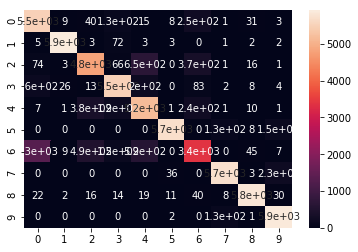

In [79]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
sns.heatmap(CM,annot=True)
plt.rcParams['figure.figsize']=(10,10)

In [80]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5516    9   40  130   15    8  247    1   31    3]
 [   5 5909    3   72    3    3    0    1    2    2]
 [  74    3 4824   66  649    0  366    1   16    1]
 [ 164   26   13 5496  204    0   83    2    8    4]
 [   7    1  378  192 5172    1  237    1   10    1]
 [   0    0    0    0    0 5710    0  131    8  151]
 [1333    9  486  149  587    0 3384    0   45    7]
 [   0    0    0    0    0   36    0 5734    3  227]
 [  22    2   16   14   19   11   40    8 5838   30]
 [   0    0    0    0    0    2    0  133    1 5864]]


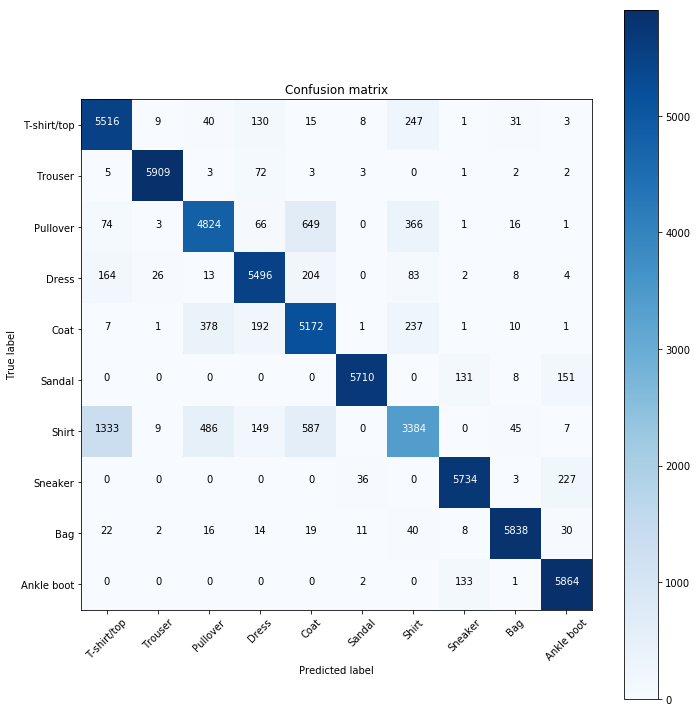

In [81]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(CM, names)

In [ ]:
#Tensorboard_visualization

In [83]:
import torch
from torch.utils.tensorboard import SummaryWriter
from itertools import product

def train(lr, batch_size, shuffle, num_epochs=5):
    # data loader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)

    # compile network
    network = Network()
    optimizer = optim.Adam(network.parameters(), lr=lr)

    # Initialize tensorboard
    tb = SummaryWriter(comment=f' lr={lr} batch_size={batch_size} shuffle={shuffle}') # this is appended
    
    # Training
    print('\nlr=', lr, 'batch_size=', batch_size, 'shuffle=', shuffle)
    for epoch in range(num_epochs): 
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch 
            preds = network(images)

            loss = F.cross_entropy(preds, labels) 
            
            optimizer.zero_grad()                 
            loss.backward()         
            optimizer.step()        

            total_loss += loss.item()*batch_size             # get absolute loss 
            total_correct += num_get_correct(preds, labels)

        tb.add_scalar('Loss', total_loss, epoch)
        tb.add_scalar('Number Correct', total_correct, epoch)
        tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

#         tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
#         tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
#         tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)

        print("epoch", epoch, "\t train_acc", total_correct / len(train_set), "\t loss:", total_loss)

    tb.close()

In [84]:
lr_list = [0.1, 0.01, 0.001,0.0001, 0.00001]
batch_size_list = [10, 100, 1000,10000]
shuffle_list = [True, False]

# hyperparameter grid search
for param in product(lr_list, batch_size_list, shuffle_list):
    train(*param, num_epochs=10)


lr= 0.1 batch_size= 10 shuffle= True
epoch 0 	 train_acc 0.0979 	 loss: 139567.67048835754
epoch 1 	 train_acc 0.0997 	 loss: 139598.02062511444
epoch 2 	 train_acc 0.10198333333333333 	 loss: 139561.49700045586
epoch 3 	 train_acc 0.1002 	 loss: 139578.06378245354
epoch 4 	 train_acc 0.1015 	 loss: 139500.8800649643
epoch 5 	 train_acc 0.10063333333333334 	 loss: 139574.63927268982
epoch 6 	 train_acc 0.0997 	 loss: 139489.852540493
epoch 7 	 train_acc 0.09778333333333333 	 loss: 139591.0008573532
epoch 8 	 train_acc 0.0995 	 loss: 139546.17162823677
epoch 9 	 train_acc 0.09643333333333333 	 loss: 139596.11682891846

lr= 0.1 batch_size= 10 shuffle= False
epoch 0 	 train_acc 0.10231666666666667 	 loss: 140403.5357093811
epoch 1 	 train_acc 0.10206666666666667 	 loss: 139448.97874355316
epoch 2 	 train_acc 0.10208333333333333 	 loss: 139448.97834300995
epoch 3 	 train_acc 0.10208333333333333 	 loss: 139448.97859811783
epoch 4 	 train_acc 0.10208333333333333 	 loss: 139448.9784169197
ep

With "lr= 0.001, batch_size= 10, shuffle= False", highest accuracy of 91.221% is achieved